# **Sentiment Analysis**

## Import Libraries and read the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
df = pd.read_csv('/content/sentiment_analysis/Tweets.csv')

In [ ]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df = df.dropna()

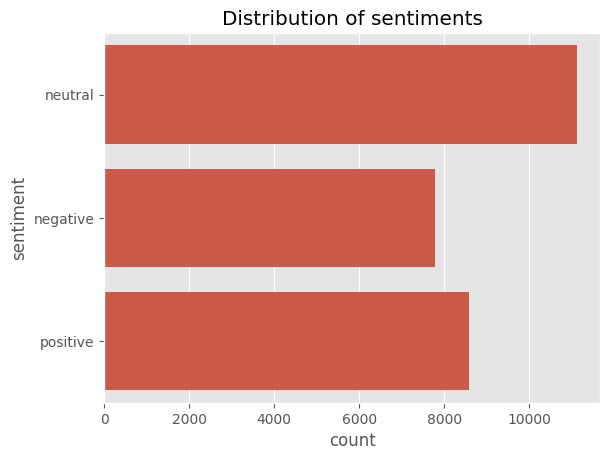

In [ ]:
sns.countplot(df['sentiment'])
plt.title('Distribution of sentiments')
plt.show()

## Basic NLTK exercise

In [ ]:
example = df['text'][13]
example

'i want to go to music tonight but i lost my voice.'

In [ ]:
nltk.download('punkt_tab')

tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['i', 'want', 'to', 'go', 'to', 'music', 'tonight', 'but', 'i', 'lost']

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


[('i', 'NN'),
 ('want', 'VBP'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('to', 'TO'),
 ('music', 'NN'),
 ('tonight', 'NN'),
 ('but', 'CC'),
 ('i', 'NN'),
 ('lost', 'VBD')]

In [ ]:
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  i/NN
  want/VBP
  to/TO
  go/VB
  to/TO
  music/NN
  tonight/NN
  but/CC
  i/NN
  lost/VBD
  my/PRP$
  voice/NN
  ./.)


## Data Processing

In [ ]:
df1 = df.drop({'textID', 'selected_text'}, axis=1).copy()

In [ ]:
df1.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
nltk.download('stopwords')

def remove_stopwords(text):
  stop_words = nltk.corpus.stopwords.words('english')
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  return ' '.join(tokens)

df1['tokens'] = df1['text'].apply(remove_stopwords)
df1[['tokens', 'text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tokens,text
0,"` responded , going","I`d have responded, if I were going"
1,sooo sad miss san diego ! ! !,Sooo SAD I will miss you here in San Diego!!!
2,boss bullying ...,my boss is bullying me...
3,interview ! leave alone,what interview! leave me alone
4,"sons * * * * , ` put releases already bought","Sons of ****, why couldn`t they put them on t..."


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Load the pre-trained model and tokenizer
roberta = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(roberta)
model = AutoModelForSequenceClassification.from_pretrained(roberta)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def polarity_scores(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'Negative': scores[0],
      'Neutral': scores[1],
      'Positive': scores[2]
  }
  return scores_dict

In [ ]:
df1["id"] = range(1, len(df1) + 1)

X = df1.drop(columns=["sentiment"])
y = df1["sentiment"]

In [ ]:
res = {}
for i, row in X.iterrows():
  text = row['tokens']
  myid = row['id']
  res[myid] = polarity_scores(text)

In [ ]:
res = pd.DataFrame(res).T
res = res.reset_index().rename(columns={'index': 'id'})
res = pd.merge(res, df1, how='right')

In [ ]:
res.head()

,id,Negative,Neutral,Positive,text,sentiment,tokens
0,1,0.024746,0.780502,0.194752,"I`d have responded, if I were going",neutral,"` responded , going"
1,2,0.937606,0.053712,0.008682,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego ! ! !
2,3,0.662277,0.315691,0.022032,my boss is bullying me...,negative,boss bullying ...
3,4,0.409279,0.539452,0.051269,what interview! leave me alone,negative,interview ! leave alone
4,5,0.055307,0.869780,0.074913,"Sons of ****, why couldn`t they put them on t...",negative,"sons * * * * , ` put releases already bought"


In [ ]:
# Define the sentiment categories
sentiment_categories = ['negative', 'neutral', 'positive']

# Get the column with the highest probability
res['predicted_sentiment'] = res[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)

# Replace column names with sentiment labels
res['predicted_sentiment'] = res['predicted_sentiment'].replace({'Negative': 'negative', 'Neutral': 'neutral', 'Positive': 'positive'})

# Display the updated DataFrame
res[['Negative', 'Neutral', 'Positive', 'predicted_sentiment']].head()


,Negative,Neutral,Positive,predicted_sentiment
0,0.024746,0.780502,0.194752,neutral
1,0.937606,0.053712,0.008682,negative
2,0.662277,0.315691,0.022032,negative
3,0.409279,0.539452,0.051269,neutral
4,0.055307,0.869780,0.074913,neutral


In [ ]:
res.dropna(inplace=True)

Accuracy: 0.6956



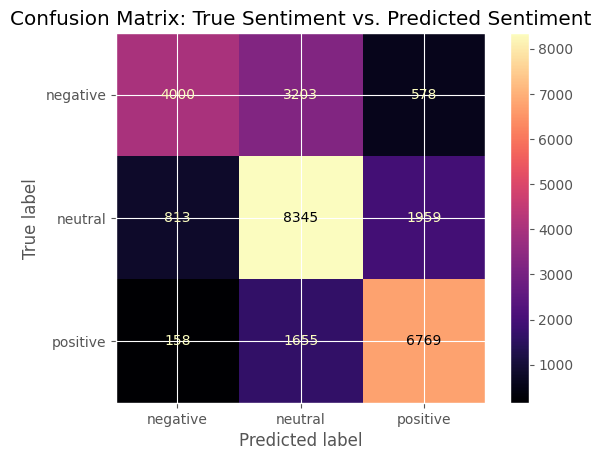


Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.51      0.63      7781
     neutral       0.63      0.75      0.69     11117
    positive       0.73      0.79      0.76      8582

    accuracy                           0.70     27480
   macro avg       0.72      0.68      0.69     27480
weighted avg       0.71      0.70      0.69     27480



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure all sentiment values are strings
res['sentiment'] = res['sentiment'].astype(str)
res['predicted_sentiment'] = res['predicted_sentiment'].astype(str)

# Calculate accuracy
accuracy = accuracy_score(res['sentiment'], res['predicted_sentiment'])
print(f'Accuracy: {accuracy:.4f}\n')

# Define label order
labels = ['negative', 'neutral', 'positive']

# Create and display the confusion matrix
cm = confusion_matrix(res['sentiment'], res['predicted_sentiment'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='magma')
plt.title('Confusion Matrix: True Sentiment vs. Predicted Sentiment')
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(res['sentiment'], res['predicted_sentiment'], target_names=labels))
